# Project: Convolutional Neural Network - Classification of Food Pictures


In [2]:
root_dir='./food-11/training/'

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
count = 0
import os
for dirname, _, filenames in os.walk(root_dir):
    for filename in filenames:
        # print(os.listdir(os.path.join(dirname, filename)))
        count+=1
print(count)

9866


In [3]:
# data anlysis 
import os
import pandas as pd
import numpy as np
import time

# neural networks 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# plotting 
import matplotlib.pyplot as plt

# picture manipulation
import cv2
import torchvision.transforms as transforms
from skimage import io, transform

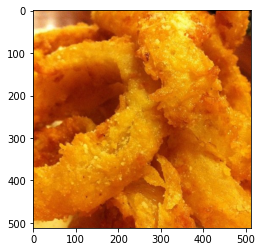

In [4]:
# explore pictures in the training set 
import matplotlib.image as mpimg
p2 = 'food-11/training/2_455.jpg'
p1 = 'food-11/training/6_25.jpg'
p3 = 'food-11/training/4_759.jpg'
img = mpimg.imread(p3)
imgplot = plt.imshow(img)
plt.show()

#Read image
Use OpenCV (cv2) to read pictures and store in numpy array.
Label is the number before '_' in the name of each picture, with 14 different kinds.
Resize the pictures into 128 * 128 * 3 format。



In [5]:
def readfile(path, label): 
  images = sorted(os.listdir(path))
  # print(images)
  x = np.zeros((len(images), 128, 128, 3), dtype=np.uint8)
  y = np.zeros((len(images)), dtype=np.uint8)
  for i, file in enumerate(images):
    # if i>2: break
    pict = cv2.imread(os.path.join(path, file))
    x[i, :, :] = cv2.resize(pict, (128, 128))
    # print( x[i, :, :, :])
    if label == True:
      y[i] = int(file.split('_')[0])
      # print(int(file.split('_')[0]))
  if label: return x, y
  else: return x

In [6]:
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# Dataset
Decorate the datasets using *Dataset* in *torch.utils.data* and *DataLoader* for training and testing.

Overload 2 functions in the *Dataset：*\_\_len\_\_ and \_\_getitem\_\_

\_\_len\_\_ returns the size of the dataset， while \_\_getitem\_\_ defines the return values with indexing method of [ ].

These 2 functions are used in DataLoader while enumerating Dataset.


In [7]:
# Do data augmentation for training
# compose: used to pack multiple operations into one
train_transform = transforms.Compose([
    transforms.ToPILImage(),

    transforms.RandomHorizontalFlip(), # randomely horizontaly flip the picture
    transforms.RandomRotation(15), # randomly rotate thhe picture

    transforms.ToTensor(), # transform the picture into Tensor, and do data normalization into [0,1]
])

# no data augmentation for testing
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x # traininig data
        # label is required to be a LongTensor
        self.y = y # label
        if y is not None:
            self.y = torch.LongTensor(y) # transform numpy array to tensor 
        self.transform = transform # transform method
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [8]:
 # batch_size = 128
batch_size = 100
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Model

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dimenstion: [3, 128, 128]

        # Convolution layer
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),         # [512, 4, 4]
        )

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Training

train the model with training set and search for the best coefficients with validation set 

In [10]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # Use CrossEntropyLoss as the loss function for classification 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Use Adam as optimizer
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # activate training for the model
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # clear the gradients
        train_pred = model(data[0].cuda()) # call the forward functions
        batch_loss = loss(train_pred, data[1].cuda()) # calculate loss
        batch_loss.backward() # calculate gradients with back propagation
        optimizer.step() # update gradients

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        # print training results 
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))

[001/030] 24.61 sec(s) Train Acc: 0.237584 Loss: 0.022922 | Val Acc: 0.254227 loss: 0.021515
[002/030] 24.48 sec(s) Train Acc: 0.338232 Loss: 0.018867 | Val Acc: 0.371137 loss: 0.018136
[003/030] 24.64 sec(s) Train Acc: 0.405129 Loss: 0.017024 | Val Acc: 0.310787 loss: 0.020692
[004/030] 24.70 sec(s) Train Acc: 0.447395 Loss: 0.015947 | Val Acc: 0.437026 loss: 0.016220
[005/030] 24.78 sec(s) Train Acc: 0.492195 Loss: 0.014663 | Val Acc: 0.404956 loss: 0.019063
[006/030] 24.87 sec(s) Train Acc: 0.516116 Loss: 0.013868 | Val Acc: 0.406122 loss: 0.019123
[007/030] 24.93 sec(s) Train Acc: 0.548044 Loss: 0.013022 | Val Acc: 0.511953 loss: 0.014459
[008/030] 24.96 sec(s) Train Acc: 0.574397 Loss: 0.012195 | Val Acc: 0.504082 loss: 0.014645
[009/030] 25.04 sec(s) Train Acc: 0.600851 Loss: 0.011588 | Val Acc: 0.424490 loss: 0.019057
[010/030] 25.11 sec(s) Train Acc: 0.618893 Loss: 0.011018 | Val Acc: 0.530321 loss: 0.014720
[011/030] 25.13 sec(s) Train Acc: 0.639266 Loss: 0.010293 | Val Acc: 0

training with both the vaidation set and training set after first-step estimations of good coeeficients

In [11]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [ ]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) 
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/030] 29.24 sec(s) Train Acc: 0.247217 Loss: 0.021619
[002/030] 29.46 sec(s) Train Acc: 0.377407 Loss: 0.017699
[003/030] 29.58 sec(s) Train Acc: 0.454272 Loss: 0.015656
[004/030] 29.67 sec(s) Train Acc: 0.507671 Loss: 0.014325
[005/030] 29.74 sec(s) Train Acc: 0.549865 Loss: 0.013064
[006/030] 29.83 sec(s) Train Acc: 0.589350 Loss: 0.012030
[007/030] 29.87 sec(s) Train Acc: 0.612289 Loss: 0.011115
[008/030] 29.90 sec(s) Train Acc: 0.637936 Loss: 0.010459
[009/030] 29.97 sec(s) Train Acc: 0.666742 Loss: 0.009646
[010/030] 29.93 sec(s) Train Acc: 0.680355 Loss: 0.009261
[011/030] 29.99 sec(s) Train Acc: 0.705325 Loss: 0.008525
[012/030] 30.05 sec(s) Train Acc: 0.719991 Loss: 0.008211
[013/030] 30.02 sec(s) Train Acc: 0.738493 Loss: 0.007530
[014/030] 30.07 sec(s) Train Acc: 0.752783 Loss: 0.007131
[015/030] 30.02 sec(s) Train Acc: 0.764064 Loss: 0.006809
[016/030] 30.05 sec(s) Train Acc: 0.771360 Loss: 0.006558
[017/030] 30.08 sec(s) Train Acc: 0.789185 Loss: 0.006002
[018/030] 30.1

# Testing
Make predictions

In [ ]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [17]:
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [18]:
#Write the predictions result into a csv file
with open("predict.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))

In [19]:
test_label

array([ 4,  9,  1,  0, 10,  2,  2,  2,  2,  9,  1,  9,  9,  1,  8,  1,  4,
        9,  3,  3,  1,  4,  8,  5,  9,  2,  1,  5, 10,  9,  3,  2,  2,  8,
        4,  5,  9, 10,  1,  4,  0,  4,  2,  8,  3,  0,  9])

In [23]:
from google.colab import files
files.download("predict.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>